In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading the datasets
train_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_Validation.csv')

In [4]:
# Function for preprocessing the datasets
def preprocess_data(df):
    df['local_time'] = pd.to_datetime(df['local_time'])
    for time_unit in ['Year', 'Month', 'Day', 'Hour']:
        df[time_unit] = getattr(df['local_time'].dt, time_unit.lower())
    return df.drop('local_time', axis=1)

In [5]:
# Preprocessing all datasets
train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)
validation_df = preprocess_data(validation_df)

def add_lagged_features(df, n_lags=3):
    for lag in range(1, n_lags + 1):
        df[f'Average_Temp_lag_{lag}'] = df['Average_Temp'].shift(lag)
    return df.dropna().reset_index(drop=True)

train_df = add_lagged_features(train_df)
validation_df = add_lagged_features(validation_df)
test_df = add_lagged_features(test_df)

In [ ]:
train_df.head()


,Average_Temp,MW,Year,Month,Day,Hour,Average_Temp_lag_1,Average_Temp_lag_2,Average_Temp_lag_3
0,4.492,32.79130,2021,1,1,3,4.298,4.612,5.186
1,4.066,34.10638,2021,1,1,4,4.492,4.298,4.612
2,4.208,36.87143,2021,1,1,5,4.066,4.492,4.298
3,3.968,40.34799,2021,1,1,6,4.208,4.066,4.492
4,3.684,38.24962,2021,1,1,7,3.968,4.208,4.066


In [6]:
def get_features_targets(df):
    feature_cols = ['Year', 'Month', 'Day', 'Hour', 'Average_Temp'] + [f'Average_Temp_lag_{lag}' for lag in range(1, 4)]  # Assuming 3 lags
    X = df[feature_cols]
    y = df['MW']
    return X, y


X_train, y_train = get_features_targets(train_df)
X_validation, y_validation = get_features_targets(validation_df)
X_test, y_test = get_features_targets(test_df)

In [7]:
# Evaluation Function

def calculate_metrics(actual, predicted, lower_bound=0, upper_bound=100, iqr_multiplier=1.5):
    # Excluding negative actual values if considered invalid
    valid_indices = actual > lower_bound
    actual = actual[valid_indices]
    predicted = predicted[valid_indices]

    # MAE and RMSE calculations
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    # Thresholding for outlier exclusion based on IQR
    q1, q3 = np.percentile(actual, [25, 75])
    iqr = q3 - q1
    outlier_threshold_upper = q3 + (iqr * iqr_multiplier)
    outlier_threshold_lower = q1 - (iqr * iqr_multiplier)

    valid_indices_for_mape = (actual >= outlier_threshold_lower) & (actual <= outlier_threshold_upper)
    filtered_actual = actual[valid_indices_for_mape]
    filtered_predicted = predicted[valid_indices_for_mape]

    # MAPE will be capped at 100 if it goes above 100%
    if len(filtered_actual) > 0:
        percentage_errors = np.abs((filtered_predicted - filtered_actual) / filtered_actual) * 100
        percentage_errors = np.clip(percentage_errors, None, upper_bound)
        mape = np.mean(percentage_errors)
    else:
        mape = np.nan

    # sMAPE calculation
    smape = 100/len(actual) * np.sum(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

    return mae, mape, smape, rmse

In [ ]:
pip install scikeras


In [ ]:
X_train.head()

,Year,Month,Day,Hour,Average_Temp,Average_Temp_lag_1,Average_Temp_lag_2,Average_Temp_lag_3
0,2021,1,1,3,4.492,4.298,4.612,5.186
1,2021,1,1,4,4.066,4.492,4.298,4.612
2,2021,1,1,5,4.208,4.066,4.492,4.298
3,2021,1,1,6,3.968,4.208,4.066,4.492
4,2021,1,1,7,3.684,3.968,4.208,4.066


In [ ]:
y_train.head()

0    32.79130
1    34.10638
2    36.87143
3    40.34799
4    38.24962
Name: MW, dtype: float64

In [ ]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib  # For saving the model


exog_vars = ['Average_Temp', 'Average_Temp_lag_1', 'Average_Temp_lag_2', 'Average_Temp_lag_3']
exog = X_train[exog_vars]

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=exog, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0), enforce_stationarity=False, enforce_invertibility=False)
fitted_model = model.fit(disp=False)

# Once the model is fitted, the model is then saved
model_save_path = '/content/drive/MyDrive/Saved_trained_models/best_SARIMAX_model.pkl'
joblib.dump(fitted_model, model_save_path)

print("Model saved successfully.")


Model saved successfully.


['/content/drive/MyDrive/Saved_trained_models/best_rnn_model_v2.h5']

In [8]:
from joblib import load
model_save_path = '/content/drive/MyDrive/Saved_trained_models/best_SARIMAX_model.pkl'
# Loading the model
loaded_model = load(model_save_path)

In [9]:
X_validation.head()

,Year,Month,Day,Hour,Average_Temp,Average_Temp_lag_1,Average_Temp_lag_2,Average_Temp_lag_3
0,2023,1,1,2,6.728,7.298,7.888,7.802
1,2023,1,1,3,6.594,6.728,7.298,7.888
2,2023,1,1,4,6.034,6.594,6.728,7.298
3,2023,1,1,5,6.060,6.034,6.594,6.728
4,2023,1,1,6,6.106,6.060,6.034,6.594


In [11]:
exog_validation = X_validation[['Average_Temp', 'Average_Temp_lag_1', 'Average_Temp_lag_2', 'Average_Temp_lag_3']]
# Assuming `fitted_model` is your SARIMAX model fitted on the training data
predictions_validation_v2 = loaded_model.predict(start=y_validation.index[0], end=y_validation.index[-1], exog=exog_validation)


# Calculate metrics
metrics_validation_v2 = calculate_metrics(y_validation, predictions_validation_v2.ravel())
print("Validation Metrics for V2 SARIMAX (MAE, MAPE, sMAPE, RMSE):", metrics_validation_v2)


Validation Metrics for V2 SARIMAX (MAE, MAPE, sMAPE, RMSE): (32.13032362704486, 41.295054308957276, 51.61219368179598, 57.32778495113684)


In [ ]:
X_test.head()

,Year,Month,Day,Hour,Average_Temp,Average_Temp_lag_1,Average_Temp_lag_2,Average_Temp_lag_3
0,2024,1,1,3,6.106,6.122,6.956,7.178
1,2024,1,1,4,5.430,6.106,6.122,6.956
2,2024,1,1,5,5.270,5.430,6.106,6.122
3,2024,1,1,6,5.122,5.270,5.430,6.106
4,2024,1,1,7,4.956,5.122,5.270,5.430


In [12]:
exog_test = X_test[['Average_Temp', 'Average_Temp_lag_1', 'Average_Temp_lag_2', 'Average_Temp_lag_3']]

# Assuming `loaded_model` is your SARIMAX model loaded from before
# Adjust the `start` and `end` parameters based on your `y_test` index if necessary
predictions_test_v2 = loaded_model.predict(start=y_test.index[0], end=y_test.index[-1], exog=exog_test)

# Calculate metrics
metrics_test_v2 = calculate_metrics(y_test, predictions_test_v2.ravel())
print("Test Metrics for V2 SARIMAX (MAE, MAPE, sMAPE, RMSE):", metrics_test_v2)


Test Metrics for V2 SARIMAX (MAE, MAPE, sMAPE, RMSE): (38.19188693628921, 39.167689574599606, 56.124540583327324, 82.49802915920668)


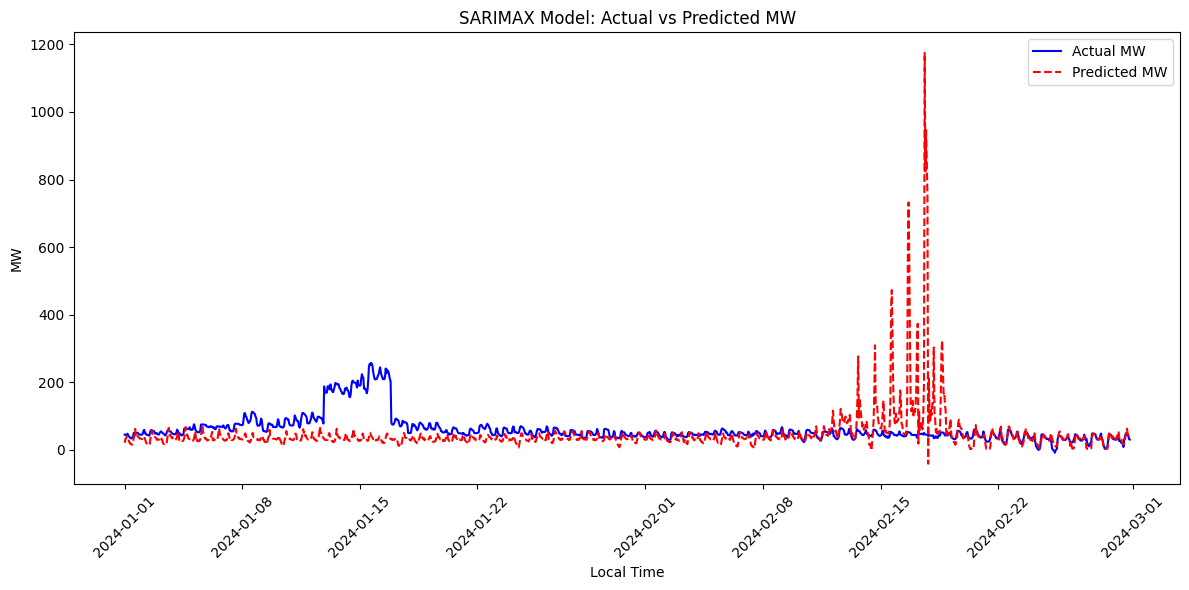

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Loading the 'local_time' column from the test dataset
test_df_for_plotting = pd.read_csv('/content/drive/MyDrive/FYP_2024/Final_test.csv', usecols=['local_time'])
test_local_time = pd.to_datetime(test_df_for_plotting['local_time'])

if len(test_local_time) > len(predictions_test_v2):
    test_local_time = test_local_time[:len(predictions_test_v2)]

plt.figure(figsize=(12, 6))
plt.plot(test_local_time, y_test[:len(test_local_time)], label='Actual MW', color='blue')
plt.plot(test_local_time, predictions_test_v2, label='Predicted MW', color='red', linestyle='--')
plt.title('SARIMAX Model: Actual vs Predicted MW')
plt.xlabel('Local Time')
plt.ylabel('MW')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
